In [105]:
import yaml
from scipy.ndimage import map_coordinates
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib as mpl
from astropy import constants, units
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.size'] = 20
path = '/Users/arcticfox/Documents/disks/models'
parula = np.load('/Users/arcticfox/parula_colors.npy')

In [2]:
def open_pickles(path):
    with open(os.path.join(path,'diskdata.pkl'), 'rb') as infile:
              diskinp = pickle.load(infile)
              ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze = diskinp
    return ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze

def pressure_profile(rho, T, mu=2.3):
    rho = rho * units.g / units.cm**3
    T = T * units.K
    
    kB = 1.3806*10**-23 * units.Joule / units.K
    mH = 1.67*10**-24 * units.g
    
    cs = (kB * T) / (mu * mH)
    P = rho * cs
    return P.to(units.Joule/units.cm**3)

In [3]:
def plot_contour(data, cmap, ticks, ax, label, index=5, contourcolor=['k'], 
                 skipticks=0, logNorm=False, xlim=None, ylim=None, 
                 pressure=False, mu=2.3, add_cbar=True, add_xlabel=True):
    
    cmap = mpl.cm.get_cmap(cmap)
    cmap.set_under('w')
    cmap.set_over(cmap(1.0))
    
    if pressure == False:
        dat = data[index] + 0.0
    else:
        dat = pressure_profile(data[4], data[5], mu=mu).value
    
    if logNorm == False:
        im = ax.pcolormesh(data[-2], data[-1], dat, cmap=cmap,
                           vmin=np.nanmin(ticks), vmax=np.nanmax(ticks))#,
                       #norm=mpl.colors.LogNorm(vmin=np.nanmin(ticks), vmax=np.nanmax(ticks)))
    else:
        im = ax.pcolormesh(data[-2], data[-1], dat, cmap=cmap,
                           norm=mpl.colors.LogNorm(vmin=np.nanmin(ticks), 
                                                   vmax=np.nanmax(ticks)))
        
    ax.contour(data[-2], data[-1], dat, ticks, colors=contourcolor)
    div = make_axes_locatable(ax)
    if add_cbar:
        cax = div.append_axes('top', size='6%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=ticks[skipticks:])
        cbar.set_label(label, fontsize=16)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.tick_params(labelsize = 14)
    if add_xlabel:
        ax.set_xlabel('R [AU]')
    
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    
    ax.set_rasterized(True)
    
    return

In [4]:
def make_subplots(data_paths, labels, transparent=False):
    fig, axes = plt.subplots(ncols=4, nrows=len(data_paths), 
                             figsize=(8*len(data_paths), 6*len(data_paths)), sharex=True)
    
    if transparent==False:
        fig.set_facecolor('w')
    
    i = 0
    x = 0
    data = [open_pickles(j) for j in data_paths]
    
    add_cbar, add_xlabel = True, False
    for ax in axes.reshape(-1):
        
        if i>3:
            add_cbar=False
        if i > 3+4*np.arange(0,len(data_paths),1)[-2]:
            add_xlabel=True
        
        if i in 0+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'RdYlBu_r', ticks=tdust_ticks, 
                         ax=ax, label='T$_{dust, lg}$ [K]',
                         index=3,ylim=ylim,add_cbar=add_cbar,
                         add_xlabel=add_xlabel)
            ax.set_ylabel('{}'.format(labels[x]),fontsize=26)
        if i in 1+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'RdYlBu_r', ticks=tgas_ticks, 
                         ax=ax, label='T$_{gas}$ [K]', 
                         skipticks=4,ylim=ylim,add_cbar=add_cbar,
                         add_xlabel=add_xlabel)
        if i in 2+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'viridis', ticks=p_ticks, 
                         ax=ax, label=r'$P_{gas}$ [J cm$^{-3}$]',
                         logNorm=True,ylim=ylim,pressure=True,
                         add_cbar=add_cbar, add_xlabel=add_xlabel)
        if i in 3+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'plasma', ticks=dgas_ticks, 
                         ax=ax, label=r'$\rho_{gas}$ [cm$^{-3}$]',
                         index=4, logNorm=True,ylim=ylim,
                         add_cbar=add_cbar, add_xlabel=add_xlabel)

        if i >= 3+4*np.arange(0,len(data_paths),1)[x]:
            x += 1
        i += 1
        
        ax.set_rasterized(True)

    return fig

In [5]:
data_folders = ['bigdisk', 'bigdisk100_newhh', 'bigdisk100_lum', 'lstar_test']
labels = ['Quiescent', 'UV, new h', 'L+UV, new h', 'L+UV, old h']
data_paths = [os.path.join(path, i) for i in data_folders]

In [6]:
tdust_ticks = np.linspace(50,1500,9)
tgas_ticks = np.logspace(1,3.3, 10)
dgas_ticks = np.logspace(5,14,9)
p_ticks = 10**np.linspace(8,20,9)
ylim=[0,3]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals w

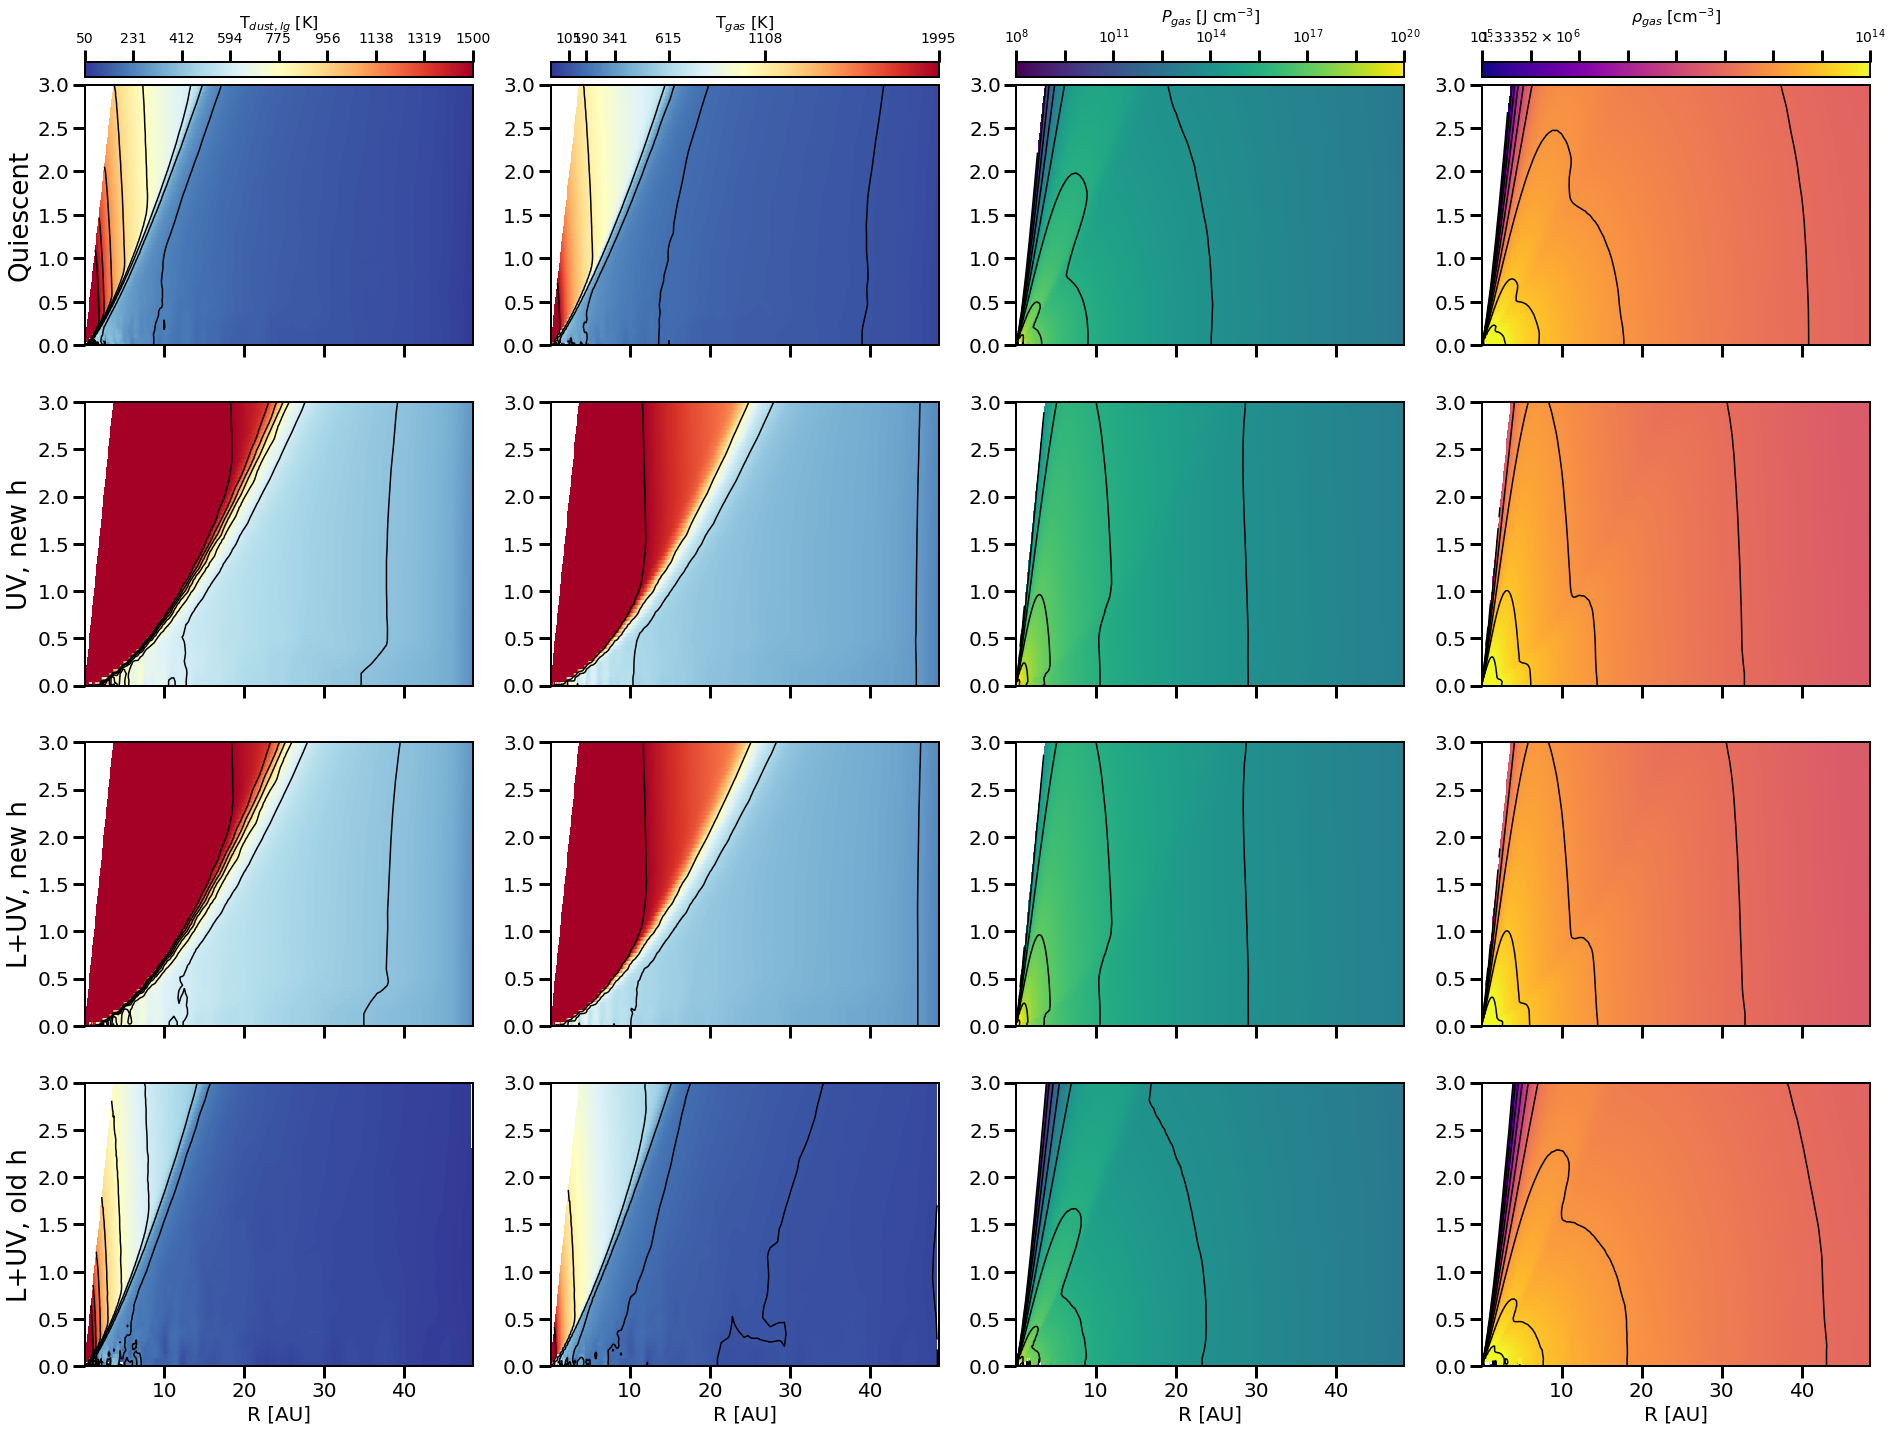

In [8]:
fig = make_subplots(data_paths, labels)
#fig.savefig('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/figures/compare_with_oldh_midplane.png',
#            rasterize=True, bbox_inches='tight', dpi=250)

In [9]:
data = [open_pickles(j) for j in data_paths]

In [14]:
def make_profiles(ax, data, zr=[0.1,0.2,0.3], labels=None, lw=2):
    z = np.linspace(31.5,0,data.shape[0])
    r = np.linspace(0,49.0,data.shape[1])
    
    c = np.linspace(0,210,len(zr), dtype=int)
    
    for i in range(len(zr)):
        if z_vals[i] == 0:
            ind = len(z)-2
        else:
            ind = np.where(z<=z_vals[i])[0][0]
        if labels is None:
            print(z_vals[i], data[ind][-1])
            ax.plot(x, data[ind], c=parula[c[i]], lw=lw)
        else:
            ax.plot(x, data[ind], c=parula[c[i]], label=labels[i], lw=lw)
    
    return

ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze

In [329]:
output_labels = [r'$\rho_{dust, small}$ [cm$^{-3}$]',
                 r'$\rho_{dust, large}$ [cm$^{-3}$]',
                 'T$_{dust, small}$ [K]',
                 'T$_{dust, large}$ [K]',
                 r'$\rho_{gas}$ [cm$^{-3}$]',
                 'T$_{gas}$ [K]',
                 'P$_{gas}$ [J cm$^{-3}$]']
output = ['rhodustsm', 'rhodustlg', 'tdustsm', 'tdustlg', 'rhogas', 'tgas', 'pressure']
tick_list = [0, 0, tdust_ticks, tdust_ticks, dgas_ticks, tgas_ticks, p_ticks]

In [281]:
d = data[0][3] + 0.0
z = np.flip(np.linspace(31.5,0,d.shape[1]))
r = np.linspace(0,49.0,d.shape[0])

In [ ]:
plot_slices(data[0])

In [372]:
def plot_slices(d, index, ax1, ax2, which='temp'):

    d = np.rot90(np.log10(d[index]))
    
    fig.set_facecolor('w')
    im = ax1.imshow(d, cmap='Greys_r', 
                    vmin=np.log10(tick_list[index]).min(), 
                    vmax=np.log10(tick_list[index]).max())

    div = make_axes_locatable(ax1)
    cax = div.append_axes('top', size='6%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbarticks = np.log10(tick_list[index])[np.linspace(0,len(tick_list[index])-1, 
                                                          4,dtype=int)]
    cbar.set_ticks(cbarticks)
    if which == 'density':
        cbt = ['10^{}'.format(i) for i in cbarticks]
        cbar.set_ticklabels(cbt)
    else:
        cbar.set_ticklabels(10**cbarticks)

    cbar.set_label(output_labels[index], fontsize=16)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize = 14)

    yticks = np.linspace(0,d.shape[0]-1,5,dtype=int)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(np.flip(np.round(z[yticks],2)))

    xticks = np.linspace(0,d.shape[1]-1,4,dtype=int)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(np.round(r[xticks],2))

    factors = np.arange(0.25,0.8,0.15)
    factors = np.append(factors, [0])
    c = parula[np.linspace(0,210,len(factors),dtype=int)]
    c = c

    for i, f in enumerate(factors):

        y0, x0 = d.shape[0]-1, 0 # These are in _pixel_ coordinates!!
        y1, x1 = (d.shape[1]-1)*f, d.shape[1]-1
        num = 1000

        x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
        #y = y[y<d.shape[0]]
        #y = np.linspace(y[0], y[1], num)

        if f == 0:
            di = d[-1,:] + 0.0
            ax1.plot([x0,x1], [d.shape[0]-10, d.shape[0]-10], '-', c=c[i], lw=3)
        else:
            di = d[y.astype(np.int), x.astype(np.int)]
            ax1.plot([x0, x1], [y0, y1], '-', c=c[i], lw=3)

        ri = np.linspace(r[0], r[-1], len(di))
        ax2.plot(ri, 10**di, c[i], lw=3, label=f)

    ax2.set_yscale('log')
    ax2.set_ylabel(output_labels[index])
    ax1.set_ylabel('z [AU]')
    ax1.set_xlabel('r [AU]')
    ax2.set_xlabel('r [AU]')
    ax2.set_ylim(np.nanmin(tick_list[index]), 
                 np.nanmax(tick_list[index])*100)
    return
#    plt.savefig('/Users/arcticfox/Documents/disks/figures/slices.png',
#                rasterize=True, bbox_inches='tight', dpi=250)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When

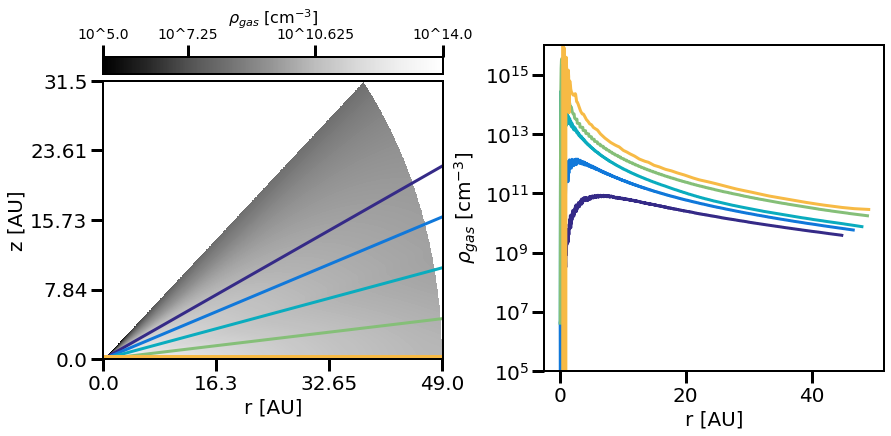

In [373]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))

plot_slices(data[0], index=4, ax1=ax1, ax2=ax2, which='density')

plt.subplots_adjust(wspace=0.3)

scale height goes as (r/150)^hh power, where hh is the scale height gradient

In [16]:
hh ~ 5

3.6308331234584013

In [336]:
np.log10(p_ticks)

array([ 8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. , 18.5, 20. ])